In [1]:
import os
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Conv1D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard
from collections import deque
from tqdm import tqdm
import random
import time
#tf.debugging.set_log_device_placement(True)

Using TensorFlow backend.


In [2]:
env = gym.make("MsPacman-v0")

In [3]:
n_outputs = env.action_space.n
print(n_outputs)
print(env.env.get_action_meanings())

9
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


In [4]:
observation = env.reset()
print(observation)
print(observation.shape)

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[228 111 111]
  [228 111 111]
  [228 111 111]
  ...
  [228 111 111]
  [228 111 111]
  [228 111 111]]

 [[228 111 111]
  [228 111 111]
  [228 111 111]
  ...
  [228 111 111]
  [228 111 111]
  [228 111 111]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(210, 160, 3)


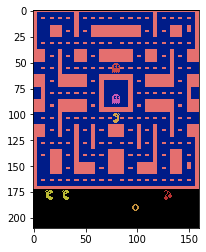

In [5]:
plt.imshow(observation)

In [6]:
color = np.array([210, 164, 74]).mean()
def preprocess_observation(obs):
    # Crop and resize the image
    img = obs[1:176:2, ::2]
    # Convert the image to greyscale
    img = img.mean(axis=2)
    # Improve image contrast
    img[img==color] = 0
    # Next we normalize the image from -1 to +1
    img = (img - 128) / 128 - 1
    return img.reshape(88,80,1)

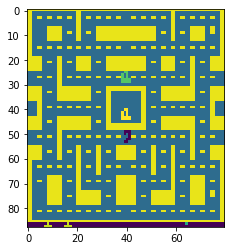

(210, 160, 3)
(88, 80)


In [7]:
obs_preprocessed = preprocess_observation(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)
obs_preprocessed = preprocess_observation(observation)

In [8]:
model = Sequential()
model.add(Conv2D(64,activation='relu',kernel_size=(3,3),input_shape=(88,80,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64,activation='relu',kernel_size=(3,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(env.action_space.n,activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#model.summary()

In [9]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 10000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 1000  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 42  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MODEL_NAME = '2x256'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
EPISODES = 300

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.005

#  Stats settings
AGGREGATE_STATS_EVERY = 50  # episodes
SHOW_PREVIEW = False

In [10]:
class DQNAgent:
    def __init__(self):
        # Main model
        self.model = self.create_model()
        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()
        model.add(Conv2D(64,activation='relu',kernel_size=(3,3),input_shape=(88,80,1)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64,activation='relu',kernel_size=(3,3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(Dense(64,activation='relu'))
        model.add(Dense(env.action_space.n,activation='linear'))
        model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
        return model

    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state, step):
        
        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states)     

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X)/255, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]



In [11]:
agent = DQNAgent()
ep_rewards = []
average_rewards = []
min_rewards = []
max_rewards = []

In [12]:
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()
    current_state,_,_,_ = env.step(0)
    current_state = preprocess_observation(current_state)
    
    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)

        new_state, reward, done, info = env.step(action)
        new_state = preprocess_observation(new_state)
        
        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1

    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    print(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_rewards.append(sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:]))
        min_rewards.append(min(ep_rewards[-AGGREGATE_STATS_EVERY:]))
        max_rewards.append(max(ep_rewards[-AGGREGATE_STATS_EVERY:]))


    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)

  0%|          | 1/300 [00:01<09:42,  1.95s/episodes]

180.0


  1%|          | 2/300 [01:12<1:52:02, 22.56s/episodes]

320.0


  1%|1         | 3/300 [03:08<4:10:29, 50.60s/episodes]

220.0


  1%|1         | 4/300 [04:57<5:35:16, 67.96s/episodes]

210.0


  2%|1         | 5/300 [06:32<6:14:48, 76.23s/episodes]

150.0


  2%|2         | 6/300 [08:51<7:45:59, 95.10s/episodes]

190.0


  2%|2         | 7/300 [10:40<8:04:01, 99.12s/episodes]

240.0


  3%|2         | 8/300 [12:15<7:56:46, 97.97s/episodes]

100.0


  3%|3         | 9/300 [13:50<7:51:07, 97.14s/episodes]

160.0


  3%|3         | 10/300 [15:37<8:03:16, 99.99s/episodes]

210.0


  4%|3         | 11/300 [17:36<8:28:43, 105.62s/episodes]

220.0


  4%|4         | 12/300 [19:23<8:29:17, 106.10s/episodes]

240.0


  4%|4         | 13/300 [21:31<8:58:37, 112.60s/episodes]

240.0


  5%|4         | 14/300 [22:59<8:21:28, 105.21s/episodes]

170.0


  5%|5         | 15/300 [25:00<8:42:13, 109.94s/episodes]

180.0


  5%|5         | 16/300 [27:17<9:20:04, 118.33s/episodes]

340.0


  6%|5         | 17/300 [29:00<8:56:21, 113.72s/episodes]

250.0


  6%|6         | 18/300 [31:12<9:19:35, 119.06s/episodes]

250.0


  6%|6         | 19/300 [32:58<8:58:42, 115.03s/episodes]

200.0


  7%|6         | 20/300 [34:50<8:53:39, 114.36s/episodes]

160.0


  7%|7         | 21/300 [36:40<8:45:21, 112.98s/episodes]

130.0


  7%|7         | 22/300 [38:07<8:06:45, 105.05s/episodes]

100.0


  8%|7         | 23/300 [40:14<8:35:44, 111.71s/episodes]

180.0


  8%|8         | 24/300 [42:04<8:31:35, 111.21s/episodes]

260.0


  8%|8         | 25/300 [43:49<8:21:26, 109.41s/episodes]

130.0


  9%|8         | 26/300 [45:32<8:09:55, 107.28s/episodes]

180.0


  9%|9         | 27/300 [47:32<8:26:01, 111.21s/episodes]

150.0


  9%|9         | 28/300 [49:10<8:06:27, 107.31s/episodes]

170.0


 10%|9         | 29/300 [51:03<8:12:18, 109.00s/episodes]

250.0


 10%|#         | 30/300 [52:52<8:11:03, 109.12s/episodes]

180.0


 10%|#         | 31/300 [54:39<8:05:17, 108.24s/episodes]

100.0


 11%|#         | 32/300 [56:50<8:34:16, 115.14s/episodes]

200.0


 11%|#1        | 33/300 [58:47<8:35:06, 115.75s/episodes]

180.0


 11%|#1        | 34/300 [1:00:08<7:46:31, 105.23s/episodes]

150.0


 12%|#1        | 35/300 [1:02:00<7:54:04, 107.34s/episodes]

190.0


 12%|#2        | 36/300 [1:03:58<8:06:05, 110.47s/episodes]

200.0


 12%|#2        | 37/300 [1:05:53<8:10:54, 111.99s/episodes]

210.0


 13%|#2        | 38/300 [1:07:50<8:15:28, 113.47s/episodes]

230.0


 13%|#3        | 39/300 [1:09:39<8:07:46, 112.13s/episodes]

350.0


 13%|#3        | 40/300 [1:11:22<7:53:52, 109.36s/episodes]

210.0


 14%|#3        | 41/300 [1:12:50<7:23:52, 102.83s/episodes]

200.0


 14%|#4        | 42/300 [1:14:56<7:52:38, 109.92s/episodes]

230.0


 14%|#4        | 43/300 [1:17:01<8:09:31, 114.29s/episodes]

270.0


 15%|#4        | 44/300 [1:19:50<9:18:08, 130.81s/episodes]

500.0


 15%|#5        | 45/300 [1:21:39<8:48:40, 124.39s/episodes]

170.0


 15%|#5        | 46/300 [1:23:11<8:04:31, 114.45s/episodes]

160.0


 16%|#5        | 47/300 [1:25:02<7:58:02, 113.37s/episodes]

170.0


 16%|#6        | 48/300 [1:27:18<8:25:34, 120.37s/episodes]

210.0


 16%|#6        | 49/300 [1:29:00<7:59:41, 114.67s/episodes]

180.0


 17%|#6        | 50/300 [1:30:45<7:45:48, 111.79s/episodes]

140.0


 17%|#7        | 51/300 [1:32:11<7:12:23, 104.19s/episodes]

110.0


 17%|#7        | 52/300 [1:34:04<7:21:04, 106.71s/episodes]

170.0


 18%|#7        | 53/300 [1:35:28<6:51:58, 100.07s/episodes]

210.0


 18%|#8        | 54/300 [1:37:34<7:22:08, 107.84s/episodes]

230.0


 18%|#8        | 55/300 [1:39:31<7:30:59, 110.45s/episodes]

200.0


 19%|#8        | 56/300 [1:41:21<7:29:11, 110.46s/episodes]

230.0


 19%|#9        | 57/300 [1:43:06<7:20:51, 108.85s/episodes]

180.0


 19%|#9        | 58/300 [1:46:14<8:54:32, 132.53s/episodes]

360.0


 20%|#9        | 59/300 [1:48:10<8:31:57, 127.46s/episodes]

230.0


 20%|##        | 60/300 [1:49:47<7:53:25, 118.36s/episodes]

210.0


 20%|##        | 61/300 [1:51:44<7:49:24, 117.84s/episodes]

150.0


 21%|##        | 62/300 [1:55:27<9:52:47, 149.45s/episodes]

530.0


 21%|##1       | 63/300 [1:57:05<8:49:03, 133.94s/episodes]

200.0


 21%|##1       | 64/300 [1:59:10<8:37:02, 131.45s/episodes]

330.0


 22%|##1       | 65/300 [2:01:02<8:11:29, 125.49s/episodes]

240.0


 22%|##2       | 66/300 [2:03:07<8:09:07, 125.42s/episodes]

170.0


 22%|##2       | 67/300 [2:04:49<7:40:14, 118.52s/episodes]

140.0


 23%|##2       | 68/300 [2:06:49<7:39:30, 118.84s/episodes]

150.0


 23%|##3       | 69/300 [2:08:34<7:21:06, 114.57s/episodes]

200.0


 23%|##3       | 70/300 [2:10:38<7:30:23, 117.49s/episodes]

250.0


 24%|##3       | 71/300 [2:12:44<7:38:28, 120.12s/episodes]

260.0


 24%|##4       | 72/300 [2:14:28<7:18:22, 115.36s/episodes]

220.0


 24%|##4       | 73/300 [2:16:35<7:29:10, 118.72s/episodes]

280.0


 25%|##4       | 74/300 [2:18:07<6:57:02, 110.72s/episodes]

200.0


 25%|##5       | 75/300 [2:19:59<6:56:32, 111.08s/episodes]

200.0


 25%|##5       | 76/300 [2:21:43<6:46:33, 108.90s/episodes]

150.0


 26%|##5       | 77/300 [2:23:44<6:58:45, 112.67s/episodes]

180.0


 26%|##6       | 78/300 [2:25:45<7:05:57, 115.12s/episodes]

230.0


 26%|##6       | 79/300 [2:27:41<7:04:32, 115.26s/episodes]

160.0


 27%|##6       | 80/300 [2:29:19<6:44:18, 110.27s/episodes]

240.0


 27%|##7       | 81/300 [2:31:35<7:10:10, 117.85s/episodes]

200.0


 27%|##7       | 82/300 [2:34:11<7:49:46, 129.30s/episodes]

340.0


 28%|##7       | 83/300 [2:35:53<7:18:27, 121.23s/episodes]

180.0


 28%|##8       | 84/300 [2:37:42<7:02:26, 117.34s/episodes]

200.0


 28%|##8       | 85/300 [2:39:49<7:11:37, 120.45s/episodes]

280.0


 29%|##8       | 86/300 [2:41:28<6:46:24, 113.95s/episodes]

160.0


 29%|##9       | 87/300 [2:43:18<6:39:54, 112.65s/episodes]

240.0


 29%|##9       | 88/300 [2:45:01<6:28:33, 109.97s/episodes]

150.0


 30%|##9       | 89/300 [2:46:44<6:19:09, 107.82s/episodes]

210.0


 30%|###       | 90/300 [2:48:36<6:21:19, 108.95s/episodes]

120.0


 30%|###       | 91/300 [2:51:00<6:56:30, 119.57s/episodes]

340.0


 31%|###       | 92/300 [2:52:47<6:41:07, 115.71s/episodes]

190.0


 31%|###1      | 93/300 [2:54:48<6:44:29, 117.24s/episodes]

210.0


 31%|###1      | 94/300 [2:56:29<6:25:47, 112.36s/episodes]

160.0


 32%|###1      | 95/300 [2:58:19<6:22:18, 111.90s/episodes]

300.0


 32%|###2      | 96/300 [3:00:10<6:19:29, 111.62s/episodes]

280.0


 32%|###2      | 97/300 [3:01:50<6:05:13, 107.95s/episodes]

170.0


 33%|###2      | 98/300 [3:03:50<6:15:43, 111.60s/episodes]

240.0


 33%|###3      | 99/300 [3:05:44<6:16:30, 112.39s/episodes]

160.0


 33%|###3      | 100/300 [3:07:30<6:08:25, 110.53s/episodes]

230.0


 34%|###3      | 101/300 [3:09:15<6:00:49, 108.79s/episodes]

130.0


 34%|###4      | 102/300 [3:11:10<6:04:45, 110.53s/episodes]

270.0


 34%|###4      | 103/300 [3:13:02<6:04:28, 111.01s/episodes]

170.0


 35%|###4      | 104/300 [3:14:55<6:04:23, 111.55s/episodes]

240.0


 35%|###5      | 105/300 [3:16:39<5:55:16, 109.32s/episodes]

210.0


 35%|###5      | 106/300 [3:18:39<6:04:29, 112.73s/episodes]

170.0


 36%|###5      | 107/300 [3:20:35<6:05:02, 113.49s/episodes]

220.0


 36%|###6      | 108/300 [3:22:02<5:38:30, 105.78s/episodes]

120.0


 36%|###6      | 109/300 [3:23:47<5:35:19, 105.34s/episodes]

230.0


 37%|###6      | 110/300 [3:25:39<5:39:48, 107.31s/episodes]

150.0


 37%|###7      | 111/300 [3:27:24<5:36:37, 106.87s/episodes]

230.0


 37%|###7      | 112/300 [3:29:19<5:41:39, 109.04s/episodes]

300.0


 38%|###7      | 113/300 [3:31:06<5:38:14, 108.52s/episodes]

110.0


 38%|###8      | 114/300 [3:32:47<5:29:17, 106.22s/episodes]

180.0


 38%|###8      | 115/300 [3:34:37<5:31:36, 107.55s/episodes]

180.0


 39%|###8      | 116/300 [3:36:26<5:30:50, 107.88s/episodes]

170.0


 39%|###9      | 117/300 [3:38:20<5:34:24, 109.64s/episodes]

230.0


 39%|###9      | 118/300 [3:40:22<5:43:38, 113.29s/episodes]

290.0


 40%|###9      | 119/300 [3:42:32<5:56:58, 118.34s/episodes]

300.0


 40%|####      | 120/300 [3:44:26<5:51:36, 117.20s/episodes]

180.0


 40%|####      | 121/300 [3:46:31<5:56:21, 119.45s/episodes]

280.0


 41%|####      | 122/300 [3:48:17<5:42:27, 115.43s/episodes]

200.0


 41%|####1     | 123/300 [3:50:09<5:37:19, 114.35s/episodes]

350.0


 41%|####1     | 124/300 [3:52:06<5:37:42, 115.13s/episodes]

220.0


 42%|####1     | 125/300 [3:53:49<5:25:32, 111.62s/episodes]

150.0


 42%|####2     | 126/300 [3:55:40<5:23:02, 111.39s/episodes]

220.0


 42%|####2     | 127/300 [3:57:42<5:30:36, 114.66s/episodes]

250.0


 43%|####2     | 128/300 [3:59:33<5:24:52, 113.33s/episodes]

220.0


 43%|####3     | 129/300 [4:01:16<5:14:20, 110.29s/episodes]

290.0


 43%|####3     | 130/300 [4:04:12<6:08:28, 130.05s/episodes]

1850.0


 44%|####3     | 131/300 [4:06:10<5:55:54, 126.36s/episodes]

250.0


 44%|####4     | 132/300 [4:08:12<5:50:49, 125.29s/episodes]

290.0


 44%|####4     | 133/300 [4:09:39<5:16:19, 113.65s/episodes]

230.0


 45%|####4     | 134/300 [4:11:25<5:08:08, 111.37s/episodes]

150.0


 45%|####5     | 135/300 [4:12:57<4:50:37, 105.68s/episodes]

160.0


 45%|####5     | 136/300 [4:14:50<4:54:22, 107.70s/episodes]

170.0


 46%|####5     | 137/300 [4:16:30<4:46:23, 105.42s/episodes]

200.0


 46%|####6     | 138/300 [4:18:02<4:34:12, 101.56s/episodes]

150.0


 46%|####6     | 139/300 [4:20:02<4:46:55, 106.93s/episodes]

270.0


 47%|####6     | 140/300 [4:21:53<4:48:37, 108.23s/episodes]

200.0


 47%|####6     | 141/300 [4:23:20<4:29:49, 101.82s/episodes]

180.0


 47%|####7     | 142/300 [4:25:13<4:37:07, 105.24s/episodes]

230.0


 48%|####7     | 143/300 [4:26:55<4:32:14, 104.04s/episodes]

190.0


 48%|####8     | 144/300 [4:28:27<4:21:39, 100.64s/episodes]

170.0


 48%|####8     | 145/300 [4:30:24<4:32:31, 105.49s/episodes]

170.0


 49%|####8     | 146/300 [4:32:21<4:39:40, 108.97s/episodes]

200.0


 49%|####9     | 147/300 [4:34:26<4:49:59, 113.72s/episodes]

280.0


 49%|####9     | 148/300 [4:36:09<4:39:59, 110.53s/episodes]

270.0


 50%|####9     | 149/300 [4:37:53<4:33:33, 108.70s/episodes]

200.0


 50%|#####     | 150/300 [4:39:46<4:34:58, 109.99s/episodes]

160.0


 50%|#####     | 151/300 [4:41:57<4:48:40, 116.24s/episodes]

250.0


 51%|#####     | 152/300 [4:43:47<4:41:58, 114.31s/episodes]

180.0


 51%|#####1    | 153/300 [4:45:51<4:47:19, 117.28s/episodes]

260.0


 51%|#####1    | 154/300 [4:47:48<4:44:39, 116.98s/episodes]

150.0


 52%|#####1    | 155/300 [4:49:59<4:52:52, 121.19s/episodes]

300.0


 52%|#####2    | 156/300 [4:51:53<4:45:49, 119.09s/episodes]

230.0


 52%|#####2    | 157/300 [4:54:43<5:20:32, 134.49s/episodes]

1070.0


 53%|#####2    | 158/300 [4:56:44<5:08:27, 130.34s/episodes]

180.0


 53%|#####3    | 159/300 [4:58:21<4:43:02, 120.45s/episodes]

160.0


 53%|#####3    | 160/300 [5:00:15<4:36:43, 118.59s/episodes]

210.0


 54%|#####3    | 161/300 [5:02:37<4:50:52, 125.56s/episodes]

330.0


 54%|#####4    | 162/300 [5:04:55<4:56:54, 129.09s/episodes]

250.0


 54%|#####4    | 163/300 [5:06:41<4:39:24, 122.37s/episodes]

300.0


 55%|#####4    | 164/300 [5:08:10<4:14:32, 112.30s/episodes]

210.0


 55%|#####5    | 165/300 [5:10:02<4:12:31, 112.23s/episodes]

180.0


 55%|#####5    | 166/300 [5:12:11<4:21:26, 117.06s/episodes]

220.0


 56%|#####5    | 167/300 [5:14:02<4:15:59, 115.49s/episodes]

300.0


 56%|#####6    | 168/300 [5:16:03<4:17:41, 117.13s/episodes]

240.0


 56%|#####6    | 169/300 [5:17:50<4:09:00, 114.05s/episodes]

210.0


 57%|#####6    | 170/300 [5:19:44<4:06:44, 113.88s/episodes]

200.0


 57%|#####6    | 171/300 [5:21:22<3:55:02, 109.32s/episodes]

160.0


 57%|#####7    | 172/300 [5:24:03<4:25:57, 124.66s/episodes]

370.0


 58%|#####7    | 173/300 [5:25:49<4:12:02, 119.08s/episodes]

150.0


 58%|#####8    | 174/300 [5:28:21<4:30:48, 128.95s/episodes]

500.0


 58%|#####8    | 175/300 [5:30:06<4:13:37, 121.74s/episodes]

260.0


 59%|#####8    | 176/300 [5:31:41<3:55:27, 113.93s/episodes]

90.0


 59%|#####8    | 177/300 [5:34:11<4:15:36, 124.68s/episodes]

400.0


 59%|#####9    | 178/300 [5:35:56<4:01:11, 118.61s/episodes]

230.0


 60%|#####9    | 179/300 [5:37:54<3:59:00, 118.52s/episodes]

160.0


 60%|######    | 180/300 [5:40:00<4:01:32, 120.77s/episodes]

310.0


 60%|######    | 181/300 [5:42:02<4:00:12, 121.11s/episodes]

230.0


 61%|######    | 182/300 [5:44:00<3:56:38, 120.33s/episodes]

230.0


 61%|######1   | 183/300 [5:46:04<3:56:39, 121.37s/episodes]

250.0


 61%|######1   | 184/300 [5:47:51<3:45:57, 116.87s/episodes]

180.0


 62%|######1   | 185/300 [5:49:31<3:34:20, 111.83s/episodes]

220.0


 62%|######2   | 186/300 [5:51:14<3:27:26, 109.18s/episodes]

180.0


 62%|######2   | 187/300 [5:53:03<3:25:52, 109.31s/episodes]

210.0


 63%|######2   | 188/300 [5:54:57<3:26:31, 110.64s/episodes]

280.0


 63%|######3   | 189/300 [5:56:52<3:27:08, 111.97s/episodes]

300.0


 63%|######3   | 190/300 [5:58:44<3:25:27, 112.07s/episodes]

200.0


 64%|######3   | 191/300 [6:00:16<3:12:32, 105.98s/episodes]

80.0


 64%|######4   | 192/300 [6:02:24<3:22:39, 112.58s/episodes]

260.0


 64%|######4   | 193/300 [6:04:14<3:19:13, 111.72s/episodes]

130.0


 65%|######4   | 194/300 [6:06:14<3:21:43, 114.19s/episodes]

200.0


 65%|######5   | 195/300 [6:07:48<3:09:17, 108.17s/episodes]

200.0


 65%|######5   | 196/300 [6:09:34<3:06:25, 107.55s/episodes]

200.0


 66%|######5   | 197/300 [6:11:15<3:01:04, 105.48s/episodes]

280.0


 66%|######6   | 198/300 [6:13:04<3:01:11, 106.58s/episodes]

180.0


 66%|######6   | 199/300 [6:14:59<3:03:43, 109.14s/episodes]

210.0


 67%|######6   | 200/300 [6:16:45<3:00:12, 108.12s/episodes]

180.0


 67%|######7   | 201/300 [6:18:07<2:45:46, 100.47s/episodes]

140.0


 67%|######7   | 202/300 [6:20:11<2:55:16, 107.31s/episodes]

320.0


 68%|######7   | 203/300 [6:22:34<3:11:00, 118.15s/episodes]

350.0


 68%|######8   | 204/300 [6:24:13<2:59:52, 112.42s/episodes]

200.0


 68%|######8   | 205/300 [6:26:22<3:06:01, 117.49s/episodes]

210.0


 69%|######8   | 206/300 [6:28:09<2:59:03, 114.30s/episodes]

170.0


 69%|######9   | 207/300 [6:30:07<2:59:00, 115.49s/episodes]

200.0


 69%|######9   | 208/300 [6:32:11<3:00:41, 117.84s/episodes]

240.0


 70%|######9   | 209/300 [6:33:44<2:47:42, 110.58s/episodes]

140.0


 70%|#######   | 210/300 [6:35:24<2:41:00, 107.34s/episodes]

200.0


 70%|#######   | 211/300 [6:37:11<2:38:49, 107.07s/episodes]

200.0


 71%|#######   | 212/300 [6:39:14<2:44:13, 111.97s/episodes]

210.0


 71%|#######1  | 213/300 [6:41:17<2:47:13, 115.33s/episodes]

230.0


 71%|#######1  | 214/300 [6:43:55<3:03:26, 127.98s/episodes]

150.0


 72%|#######1  | 215/300 [6:47:24<3:35:39, 152.22s/episodes]

190.0


 72%|#######2  | 216/300 [6:50:22<3:44:18, 160.22s/episodes]

180.0


 72%|#######2  | 217/300 [6:53:36<3:55:29, 170.23s/episodes]

220.0


 73%|#######2  | 218/300 [6:56:34<3:55:57, 172.66s/episodes]

220.0


 73%|#######3  | 219/300 [7:00:00<4:06:32, 182.62s/episodes]

270.0


 73%|#######3  | 220/300 [7:03:18<4:09:37, 187.22s/episodes]

160.0


 74%|#######3  | 221/300 [7:06:12<4:01:14, 183.23s/episodes]

150.0


 74%|#######4  | 222/300 [7:08:48<3:47:29, 174.99s/episodes]

130.0


 74%|#######4  | 223/300 [7:12:27<4:01:40, 188.32s/episodes]

160.0


 75%|#######4  | 224/300 [7:15:42<4:01:06, 190.35s/episodes]

210.0


 75%|#######5  | 225/300 [7:18:21<3:46:03, 180.85s/episodes]

250.0


 75%|#######5  | 226/300 [7:21:11<3:38:50, 177.45s/episodes]

180.0


 76%|#######5  | 227/300 [7:24:32<3:44:41, 184.67s/episodes]

180.0


 76%|#######6  | 228/300 [7:27:58<3:49:20, 191.11s/episodes]

270.0


 76%|#######6  | 229/300 [7:31:24<3:51:24, 195.56s/episodes]

250.0


 77%|#######6  | 230/300 [7:34:43<3:49:12, 196.47s/episodes]

280.0


 77%|#######7  | 231/300 [7:38:49<4:03:11, 211.47s/episodes]

230.0


 77%|#######7  | 232/300 [7:43:57<4:32:18, 240.27s/episodes]

250.0


 78%|#######7  | 233/300 [7:48:05<4:31:08, 242.82s/episodes]

250.0


 78%|#######8  | 234/300 [7:52:17<4:30:04, 245.52s/episodes]

250.0


 78%|#######8  | 235/300 [7:57:44<4:52:25, 269.93s/episodes]

260.0


 79%|#######8  | 236/300 [8:01:47<4:39:24, 261.94s/episodes]

210.0


 79%|#######9  | 237/300 [8:07:05<4:52:38, 278.70s/episodes]

200.0


 79%|#######9  | 238/300 [8:11:07<4:36:27, 267.53s/episodes]

120.0


 80%|#######9  | 239/300 [8:15:36<4:32:35, 268.12s/episodes]

240.0


 80%|########  | 240/300 [8:20:00<4:26:43, 266.72s/episodes]

180.0


 80%|########  | 241/300 [8:24:45<4:27:37, 272.16s/episodes]

270.0


 81%|########  | 242/300 [8:29:18<4:23:24, 272.50s/episodes]

250.0


 81%|########1 | 243/300 [8:34:35<4:31:34, 285.87s/episodes]

290.0


 81%|########1 | 244/300 [8:38:19<4:09:29, 267.30s/episodes]

120.0


 82%|########1 | 245/300 [8:42:24<3:58:57, 260.68s/episodes]

200.0


 82%|########2 | 246/300 [8:48:34<4:24:01, 293.37s/episodes]

320.0


 82%|########2 | 247/300 [8:52:39<4:06:17, 278.82s/episodes]

210.0


 83%|########2 | 248/300 [8:57:58<4:12:08, 290.93s/episodes]

330.0


 83%|########2 | 249/300 [9:01:51<3:52:30, 273.54s/episodes]

210.0


 83%|########3 | 250/300 [9:07:23<4:02:37, 291.16s/episodes]

250.0


 84%|########3 | 251/300 [9:10:28<3:31:46, 259.31s/episodes]

170.0


 84%|########4 | 252/300 [9:15:18<3:34:53, 268.62s/episodes]

180.0


 84%|########4 | 253/300 [9:20:26<3:39:31, 280.25s/episodes]

190.0


 85%|########4 | 254/300 [9:24:31<3:26:50, 269.78s/episodes]

160.0


 85%|########5 | 255/300 [9:29:44<3:32:03, 282.75s/episodes]

190.0


 85%|########5 | 256/300 [9:32:42<3:04:12, 251.20s/episodes]

280.0


 86%|########5 | 257/300 [9:37:49<3:11:59, 267.90s/episodes]

190.0


 86%|########6 | 258/300 [9:41:59<3:03:45, 262.52s/episodes]

150.0


 86%|########6 | 259/300 [9:46:17<2:58:39, 261.45s/episodes]

110.0


 87%|########6 | 260/300 [9:51:11<3:00:48, 271.22s/episodes]

150.0


 87%|########7 | 261/300 [9:57:59<3:22:53, 312.14s/episodes]

610.0


 87%|########7 | 262/300 [10:02:42<3:12:08, 303.38s/episodes]

260.0


 88%|########7 | 263/300 [10:09:04<3:21:32, 326.82s/episodes]

390.0


 88%|########8 | 264/300 [10:14:21<3:14:19, 323.86s/episodes]

230.0


 88%|########8 | 265/300 [10:18:45<2:58:34, 306.13s/episodes]

250.0


 89%|########8 | 266/300 [10:24:00<2:54:53, 308.65s/episodes]

200.0


 89%|########9 | 267/300 [10:28:45<2:45:48, 301.46s/episodes]

170.0


 89%|########9 | 268/300 [10:33:51<2:41:39, 303.11s/episodes]

260.0


 90%|########9 | 269/300 [10:38:45<2:35:03, 300.12s/episodes]

260.0


 90%|######### | 270/300 [10:43:22<2:26:39, 293.32s/episodes]

170.0


 90%|######### | 271/300 [10:48:51<2:26:57, 304.06s/episodes]

270.0


 91%|######### | 272/300 [10:53:45<2:20:26, 300.96s/episodes]

270.0


 91%|#########1| 273/300 [11:00:06<2:26:14, 324.99s/episodes]

620.0


 91%|#########1| 274/300 [11:05:15<2:18:48, 320.34s/episodes]

190.0


 92%|#########1| 275/300 [11:09:18<2:03:41, 296.87s/episodes]

110.0


 92%|#########2| 276/300 [11:13:11<1:51:04, 277.69s/episodes]

120.0


 92%|#########2| 277/300 [11:18:15<1:49:34, 285.86s/episodes]

280.0


 93%|#########2| 278/300 [11:22:56<1:44:11, 284.16s/episodes]

190.0


 93%|#########3| 279/300 [11:27:45<1:39:58, 285.65s/episodes]

220.0


 93%|#########3| 280/300 [11:32:18<1:34:01, 282.05s/episodes]

120.0


 94%|#########3| 281/300 [11:36:55<1:28:48, 280.43s/episodes]

180.0


 94%|#########3| 282/300 [11:41:59<1:26:14, 287.46s/episodes]

200.0


 94%|#########4| 283/300 [11:47:26<1:24:48, 299.30s/episodes]

240.0


 95%|#########4| 284/300 [11:52:30<1:20:11, 300.75s/episodes]

190.0


 95%|#########5| 285/300 [11:57:08<1:13:31, 294.08s/episodes]

230.0


 95%|#########5| 286/300 [12:02:17<1:09:38, 298.47s/episodes]

270.0


 96%|#########5| 287/300 [12:06:29<1:01:38, 284.52s/episodes]

180.0


 96%|#########6| 288/300 [12:12:16<1:00:37, 303.12s/episodes]

190.0


 96%|#########6| 289/300 [12:18:44<1:00:14, 328.58s/episodes]

230.0


 97%|#########6| 290/300 [12:24:17<54:59, 329.90s/episodes]  

180.0


 97%|#########7| 291/300 [12:30:14<50:43, 338.21s/episodes]

220.0


 97%|#########7| 292/300 [12:36:38<46:55, 351.93s/episodes]

300.0


 98%|#########7| 293/300 [12:41:52<39:43, 340.52s/episodes]

170.0


 98%|#########8| 294/300 [12:47:36<34:09, 341.59s/episodes]

240.0


 98%|#########8| 295/300 [12:57:43<35:06, 421.28s/episodes]

680.0


 99%|#########8| 296/300 [13:02:58<25:56, 389.22s/episodes]

200.0


 99%|#########9| 297/300 [13:08:56<19:00, 380.02s/episodes]

230.0


 99%|#########9| 298/300 [13:14:43<12:19, 369.90s/episodes]

200.0


100%|#########9| 299/300 [13:20:37<06:05, 365.15s/episodes]

190.0


100%|##########| 300/300 [13:26:17<00:00, 161.26s/episodes]

230.0


In [ ]:
agent.